# Imports

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve

def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

def plot_roc_curve(ax, model_output, y, **kwargs):
    """Plot ROC curve for a given set of model outputs and labels"""
    fpr, tpr, _ = roc_curve(y_score=model_output, y_true=y)
    roc_auc = auc(fpr, tpr)
    label = '{} (area={:.2f})'.format(kwargs.pop('label'), roc_auc)  # Remove label
    ax.plot(fpr, tpr, label=label, **kwargs)
    return ax

def plot_evt_roc_curve_variation(ax, data_test, cut_list, model_output_name):
    """

    Parameters
    ----------
    ax: `~matplotlib.axes.Axes`
        Axis
    data_test: `~pd.DataFrame`
        Test data
    cut_list: `list`
         Cut list

    Returns
    -------
    ax:  `~matplotlib.axes.Axes`
        Axis
    """
    color = 1.
    step_color = 1. / (len(cut_list))
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        data = data_test.query(cut)
        if len(data) == 0:
            continue

        opt = dict(color=str(c), lw=2, label='{}'.format(cut.replace('reco_energy', 'E')))
        plot_roc_curve(ax, data[model_output_name], data['label'], **opt)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    return ax

# Load data

In [2]:
# config = 'prod_full_array_north_zen20_az0_complete'
#config = 'prod_LSTs'

is_proba = True

model_output = 'score'
output_range = [-1, 1]
if is_proba is True:
    model_output = 'gammaness'
    output_range = [0, 1]

indir = '../data/DL2/'
data_gamma = pd.read_hdf(os.path.join(indir, 'dl2_tail_gamma_merged.h5'), "/reco_events").query('NTels_reco >= 2')
data_electron = pd.read_hdf(os.path.join(indir, 'dl2_tail_electron_merged.h5'), "/reco_events").query('NTels_reco >= 2')
data_proton = pd.read_hdf(os.path.join(indir, 'dl2_tail_proton_merged.h5'), "/reco_events").query('NTels_reco >= 2')

data_gamma['label'] = np.ones(len(data_gamma))
data_electron['label'] = np.zeros(len(data_electron))
data_proton['label'] = np.zeros(len(data_proton))

# Plot score distribution

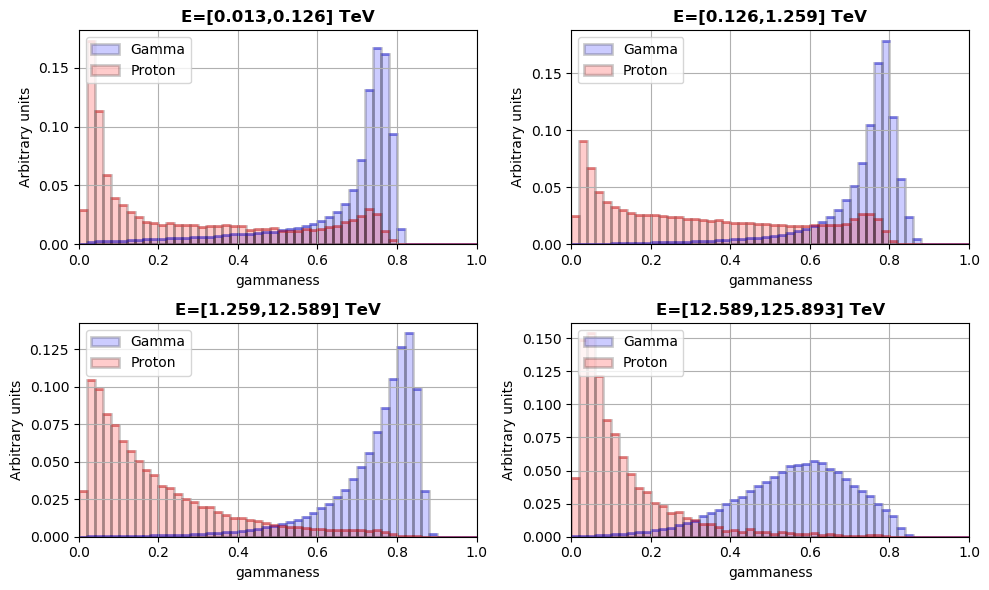

In [3]:
energy_bounds = np.logspace(np.log10(0.012589254), np.log10(125.89254), 4 + 1)
ncols = 2
n_ax = len(energy_bounds) - 1
nrows = int(n_ax / ncols) if n_ax % ncols == 0 else int((n_ax + 1) / ncols)
nrows = nrows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows))
if nrows == 1 and ncols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx in range(len(energy_bounds) - 1):
    ax = axes[idx]

    # Data selection
    query = 'mc_energy >= {} and mc_energy < {}'.format(energy_bounds[idx], energy_bounds[idx + 1])
    gamma = data_gamma.query(query)
    proton = data_proton.query(query + ' and offset < {}'.format(1.))
    electron = data_electron.query(query + ' and offset < {}'.format(1.))
    data_list = [gamma, proton]
    
    # Graphical stuff
    color_list = ['blue', 'red', 'green']
    edgecolor_list = ['black', 'black', 'green']
    fill_list = [True, True, False]
    ls_list = ['-', '-', '--']
    lw_list = [2, 2, 2]
    alpha_list = [0.2, 0.2, 1]
    label_list = ['Gamma', 'Proton', 'Electron']
    
    opt_list = []
    err_list = []
    for jdx, data in enumerate(data_list):
        opt_list.append(dict(edgecolor=edgecolor_list[jdx], color=color_list[jdx], fill=fill_list[jdx], ls=ls_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], label=label_list[jdx]))
        err_list.append(dict(ecolor=color_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], capsize=3, capthick=2,))
    
    for jdx, data in enumerate(data_list):
        ax = plot_hist(
            ax=ax, data=data[model_output], nbin=50, limit=output_range,
            norm=True, yerr=False,
            hist_kwargs=opt_list[jdx],
            error_kw=err_list[jdx],
        )
    ax.set_title('E=[{:.3f},{:.3f}] TeV'.format(energy_bounds[idx], energy_bounds[idx + 1]), fontdict={'weight': 'bold'})
    ax.set_xlabel(model_output)
    ax.set_ylabel('Arbitrary units')
    ax.set_xlim(output_range)
    ax.legend(loc='upper left')
    ax.grid()
    
plt.tight_layout()
plt.savefig('discri_{}.pdf')
plt.savefig('discri_{}.jpg')

# Plot ROC

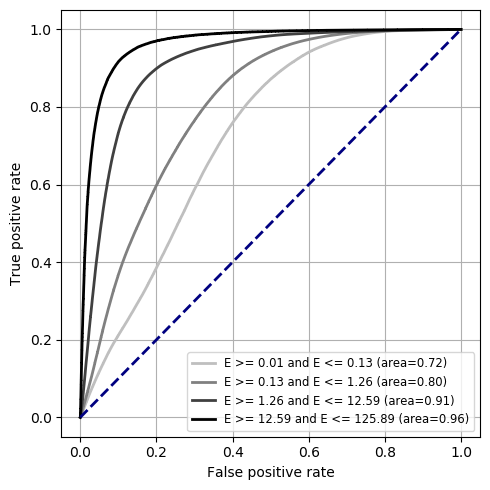

In [4]:
data = pd.concat([data_gamma, data_electron, data_proton])
plt.figure(figsize=(5,5))
ax = plt.gca()
cut_list = ['reco_energy >= {:.2f} and reco_energy <= {:.2f}'.format(
    energy_bounds[i],
    energy_bounds[i+1]
) for i in range(len(energy_bounds) - 1)]
plot_evt_roc_curve_variation(ax, data, cut_list, model_output)
ax.legend(loc='lower right', fontsize='small')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.grid()
plt.tight_layout()
plt.savefig('roc_curve_{}.pdf')
plt.savefig('roc_curve_{}.jpg')